In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

2.4.0
2.4.3


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12509034225723729310
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 8855182400
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11077256067806898337
physical_device_desc: "device: 0, name: GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6"
]


In [4]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 400)

### Loading data

In [26]:
stock_list = ['Alior Bank', 'Allegro', 'Asseco', 'CCC', 'CD Projekt', 'Cyfrowy Polsat', 'Dino Polska', 'JSW', 'KGHM', 'Lotos', 'LPP', 'Orange Polska', 'PEKAO', 'PGE', 'PGNiG', 'PKN Orlen', 'PKO BP', 'PZU', 'Santander', 'Tauron']

directory = "WiG20 data/"
stock_data_list = []
stock_data = pd.DataFrame(columns=['Date', 'Open', 'Highest', 'Lowest', 'Close', 'Volume'])

for filename in os.listdir(directory):
    file_path = os.path.join(directory, filename)
    single_stock_data = pd.read_csv(file_path)
    single_stock_data = single_stock_data.rename(columns={'Data': 'Date', 'Otwarcie': 'Open', 'Najwyzszy': 'Highest', 'Najnizszy': 'Lowest', 'Zamkniecie': 'Close', 'Wolumen': 'Volume'})
    single_stock_data['Date'] = pd.to_datetime(single_stock_data.Date)
    stock_data_list.append(single_stock_data)
    single_stock_data['Stock'] = (filename[:3]).upper()
    stock_data = stock_data.append(single_stock_data, ignore_index=True)
    print('Loaded file: ' + filename)

Loaded file: acp_d.csv
Loaded file: ale_d.csv
Loaded file: alr_d.csv
Loaded file: ccc_d.csv
Loaded file: cdr_d.csv
Loaded file: cps_d.csv
Loaded file: dnp_d.csv
Loaded file: jsw_d.csv
Loaded file: kgh_d.csv
Loaded file: lpp_d.csv
Loaded file: lts_d.csv
Loaded file: opl_d.csv
Loaded file: peo_d.csv
Loaded file: pge_d.csv
Loaded file: pgn_d.csv
Loaded file: pkn_d.csv
Loaded file: pko_d.csv
Loaded file: pzu_d.csv
Loaded file: san_d.csv
Loaded file: tpe_d.csv


In [6]:
for i in range(len(stock_data_list)):
    stock_data_list[i] = stock_data_list[i].dropna()

In [51]:
def scale_data(data):
    list_of_features = []
    list_of_outputs = []
    for column in data.columns:
        list_of_features.append(data[column])
        if column in ['Open', 'Close', 'Highest', 'Lowest', 'Volume', 'Otwarcie', 'Najwyzszy', 'Najnizszy', 'Zamkniecie', 'Wolumen']:
            list_of_outputs.append(data[column])
        
    dataset = np.transpose(list_of_features)
    output_dataset = np.transpose(list_of_outputs)
    X_scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = X_scaler.fit_transform(dataset)
    Y_scaler = MinMaxScaler(feature_range=(0,1))
    Y_scaler.fit_transform(output_dataset)

    return scaled_data, X_scaler, Y_scaler

In [52]:
def prepare_input_and_output(data, number_of_sessions=60):
    # number_of_sessions - number of considered previous sessions as an input
    X = []
    Y = []
    for i in range(number_of_sessions, data.shape[0]):
        X.append(data[i-number_of_sessions:i, :])
        Y.append(data[i, :5])
    return X, Y

In [53]:
# Evaluation of the results is made on closing prices - it gives the most information about the usefullness of the model

def evaluate_results(X_valid, Y_valid, Y_scalers, predictions):

    predictions = Y_scalers[-1].inverse_transform(predictions)
    real_output = Y_scalers[-1].inverse_transform(Y_valid)

    predicted_data = pd.DataFrame(predictions, columns=['Open_predicted', 'Close_predicted', 'Highest_predicted', 'Lowest_predicted', 'Volume_predicted'])
    real_data = pd.DataFrame(real_output, columns=['Open_real', 'Close_real', 'Highest_real', 'Lowest_real', 'Volume_real'])
    predictions = pd.concat([real_data, predicted_data], axis=1)
    print(predictions[['Close_real', 'Close_predicted']].tail(20))

    predictions['Close_difference'] = abs(predictions['Close_real'] - predictions['Close_predicted'])
    predictions['Close_difference_percent'] = abs(predictions['Close_real'] - predictions['Close_predicted'])/predictions['Close_real'] * 100

    previous_close = predictions['Close_real'].shift(-1)
    Naive_forcast_MAPE = (abs(predictions['Close_real'] - previous_close)/predictions['Close_real'] * 100).mean()
    predictions_MAPE = predictions['Close_difference_percent'].mean()

    print('Naive forcast MAE: ' + str(round(abs(previous_close - predictions['Close_real']).mean(),2)))
    print('Predictions MAE: ' + str(round(predictions['Close_difference'].mean(),2)))
    print('Naive forcast MAPE: ' + str(round(Naive_forcast_MAPE,2)) + '%')
    print('Predictions MAPE: ' + str(round(predictions_MAPE,2)) + '%')
    
    return predictions

In [54]:
scaled_stocks = []
X_scalers = []
Y_scalers = []

for i in range(len(stock_data_list)):
    # Date is dropped as it isn't considered for learning
    scaled_stock, X_scaler, Y_scaler = scale_data(stock_data_list[i].drop(columns=['Stock', 'Date']))
  
    scaled_stocks.append(scaled_stock)
    X_scalers.append(X_scaler)
    Y_scalers.append(Y_scaler)

In [11]:
X_all = []
Y_all = []
scaled_X_list = []
scaled_Y_list = []

for stock in scaled_stocks:
    X, Y = prepare_input_and_output(stock, 60)
    scaled_X_list.append(np.array(X))
    scaled_Y_list.append(np.array(Y))
    X_all = X_all + X
    Y_all = Y_all + Y

X_all, Y_all = np.array(X_all), np.array(Y_all)
print('Shape of input matrix: ' + str(X_all.shape))
print('Shape of output matrix: ' + str(Y_all.shape))

Shape of input matrix: (76328, 60, 5)
Shape of output matrix: (76328, 5)


In [12]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X_all, Y_all, test_size=2666 - 60, shuffle=False)

### Defining and evaluating the model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                17920     
_________________________________________________________________
dense (Dense)                (None, 100)               6500      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 24,925
Trainable params: 24,925
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
2304/2304 [==============================] - 13s 4ms/step - loss: 0.0036 - val_loss: 3.9105e-04
Epoch 2/15
2304/2304 [==============================] - 10s 4ms/step - loss: 5.0249e-04 - val_loss: 3.3650e-04
Epoch 3/15
2304/2304 [==============================] - 9s 4ms/step - loss: 4.7152e-04 - val_loss: 3.6281e-04
Epoch 4/15
2304/2304 [==============================] 

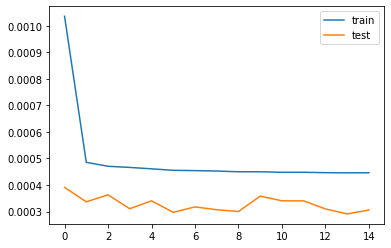

In [13]:
model = Sequential()
model.add(LSTM(64, input_shape=[X_train.shape[1], X_train.shape[2]]))#, return_sequences=True))
#model.add(LSTM(64))
model.add(Dense(100, activation='relu'))
model.add(Dense(Y_train.shape[1]))

model.summary()

model.compile(loss='mse', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=15, validation_data=(X_valid, Y_valid))

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [14]:
predictions = model.predict(X_valid)

predictions = evaluate_results(X_valid, Y_valid, Y_scalers, predictions) # returns dataset

      Close_real  Close_predicted
2586       2.858         2.913856
2587       2.860         2.927402
2588       2.868         2.892530
2589       2.936         2.937411
2590       2.910         2.969304
2591       2.850         2.873904
2592       2.848         2.884586
2593       2.830         2.901360
2594       2.814         2.847094
2595       2.820         2.854899
2596       2.798         2.851611
2597       2.780         2.843229
2598       2.746         2.798818
2599       2.682         2.777215
2600       2.644         2.705983
2601       2.600         2.607215
2602       2.600         2.620789
2603       2.598         2.590532
2604       2.630         2.653064
2605       2.620         2.642532
Naive forcast MAE: 0.04
Predictions MAE: 0.05
Naive forcast MAPE: 1.31%
Predictions MAPE: 1.56%


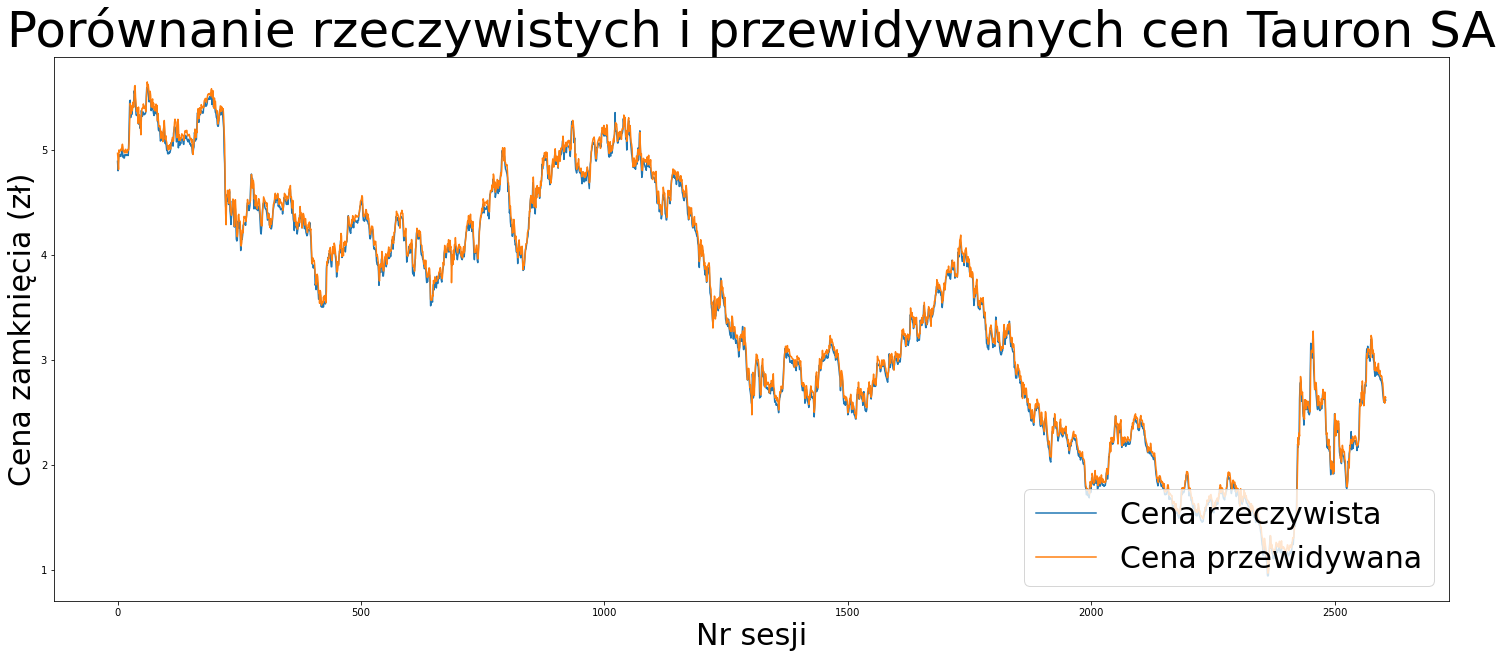

In [15]:
plt.figure(figsize=(25,10))
plt.title('Porównanie rzeczywistych i przewidywanych cen Tauron SA', fontsize=50)
plt.xlabel('Nr sesji', fontsize=30)
plt.ylabel('Cena zamknięcia (zł)', fontsize=30)
plt.plot(predictions['Close_real'])
plt.plot(predictions['Close_predicted'])
plt.legend(['Cena rzeczywista',  'Cena przewidywana'], loc='lower right', fontsize=30)
plt.show()

### Predictions on multiple days

In [17]:
X_valid_1 = np.roll(X_valid, -1, axis=1)

In [20]:
for idx in range(X_valid[:5,:,:].shape[0]):
    print(X_valid_1[idx,-1,:])
    print('\n')

[0.69946877 0.69122045 0.69069827 0.68458043 0.97445439]


[0.67791963 0.67829099 0.68177734 0.684177   0.20763848]


[0.68657356 0.68175462 0.69735153 0.68587566 0.05469336]


[0.68657356 0.68003356 0.69735153 0.684177   0.04492853]


[0.68657356 0.68175462 0.69906298 0.68761678 0.04078629]




In [27]:
stock_data

,Date,Open,Highest,Lowest,Close,Volume,Stock
0,1998-06-02,11.071,11.071,11.071,11.071,553241,ACP
1,1998-06-03,12.163,12.163,12.163,12.163,212085,ACP
2,1998-06-04,13.255,13.255,13.255,13.255,628114,ACP
3,1998-06-05,13.415,13.415,13.415,13.415,241411,ACP
4,1998-06-08,13.360,13.360,13.360,13.360,135799,ACP
...,...,...,...,...,...,...,...
77524,2021-02-24,2.500,2.600,2.482,2.524,5424053,TPE
77525,2021-02-25,2.560,2.600,2.472,2.500,6324046,TPE
77526,2021-02-26,2.470,2.598,2.450,2.560,8567511,TPE
77527,2021-03-01,2.620,2.630,2.524,2.562,4569881,TPE


In [148]:
# passed values are input_vector sized (60, 5) (60 days * 5 features - Open, Highest, Lowest, Close, Volume) and n number of days we want to predict 
# returns vector (n, 5) with predictions
def predict_n_days(input_vector, n):
    scaler = MinMaxScaler(feature_range=(0,1))
    X = scaler.fit_transform(input_vector)
    X = np.array(X).reshape(1, 60, 5)
    X_predicted = X
    predictions = []
    
    for day in range(n):
        prediction = model.predict(X_predicted)
        X_predicted = np.roll(X_predicted, -1, axis=1)
        X_predicted[:, -1, :] = prediction
        predictions.append(prediction)
    
    X_predicted = scaler.inverse_transform(X_predicted.reshape(60, 5))
    predictions = np.array(predictions)
    predictions = scaler.inverse_transform(predictions.reshape(n, 5))
    
    return (predictions)

In [160]:
predictions_30 = predict_n_days(stock_data.loc[stock_data['Stock'] == 'TPE', ['Open', 'Highest', 'Lowest', 'Close', 'Volume']][2000:2060], 30)

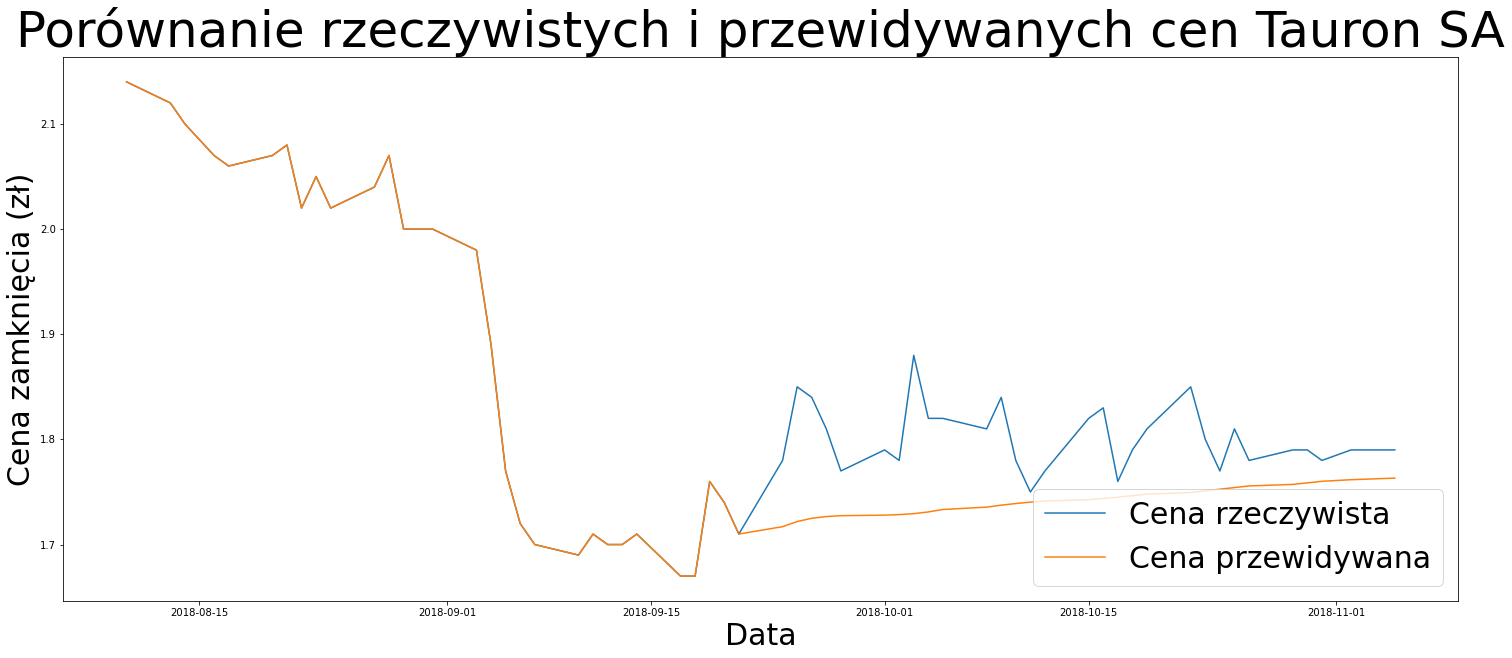

In [161]:
plt.figure(figsize=(25,10))
plt.title('Porównanie rzeczywistych i przewidywanych cen Tauron SA', fontsize=50)
plt.xlabel('Data', fontsize=30)
plt.ylabel('Cena zamknięcia (zł)', fontsize=30)
plt.plot(stock_data.loc[stock_data['Stock'] == 'TPE', 'Date'][2030:2090].values, stock_data.loc[stock_data['Stock'] == 'TPE', 'Close'][2030:2090].values)
plt.plot(stock_data.loc[stock_data['Stock'] == 'TPE', 'Date'][2030:2090].values, np.concatenate((stock_data.loc[stock_data['Stock'] == 'TPE', 'Close'][2030:2060].values, predictions_30[:, 3])))
plt.legend(['Cena rzeczywista',  'Cena przewidywana'], loc='lower right', fontsize=30)
plt.show()

In [84]:
for idx in stock_data.loc[stock_data[]]

array([[4.78020000e+00, 4.84510000e+00, 4.76170000e+00, 4.77090000e+00,
        1.47201600e+06],
       [4.73390000e+00, 4.84510000e+00, 4.73390000e+00, 4.83580000e+00,
        1.20794300e+06],
       [4.83580000e+00, 4.84510000e+00, 4.66900000e+00, 4.76170000e+00,
        1.70441300e+06],
       [4.78020000e+00, 4.80800000e+00, 4.71540000e+00, 4.72460000e+00,
        1.26841900e+06],
       [4.74320000e+00, 4.78950000e+00, 4.68750000e+00, 4.69690000e+00,
        8.50053000e+05],
       [4.71540000e+00, 4.78020000e+00, 4.68750000e+00, 4.69690000e+00,
        9.01100000e+05],
       [4.70610000e+00, 4.80800000e+00, 4.70610000e+00, 4.72460000e+00,
        2.28428100e+06],
       [4.73390000e+00, 4.77090000e+00, 4.67830000e+00, 4.68750000e+00,
        1.72812900e+06],
       [4.68750000e+00, 4.73390000e+00, 4.59500000e+00, 4.64130000e+00,
        3.98062100e+06],
       [4.66900000e+00, 4.67830000e+00, 4.64130000e+00, 4.65980000e+00,
        3.29909900e+06],
       [4.65980000e+00, 4.7895